# Coupling the finite and boundary element methods

In this tutorial, we will look at how Bempp can be used alongside the finite element library FEniCSx to solve a transmission problem. To run this tutorial, you will need to have FEniCSx installed. FEniCSx is included in the [Bempp Docker image](https://bempp.com/installation.html), so you may like to use that rather than installing FEniCSx yourself.

For this example, we let $\Omega$ be a unit cube and we solve a transmission problem with different matrial properties inside and outside the cube.

As an incident wave, we use

$$
p_\text{inc}(\mathbf{x})=\mathrm{e}^{\mathrm{i} k \mathbf{x}\cdot\mathbf{d}},
$$

where $\mathbf{x}=(x_0,x_1,x_2)$ and $\mathbf{d} = \frac{1}{\sqrt{3}}(1,1,1)$ is the direction of the incident wave.

The PDE we want to solve is

$$
\Delta p + n(\mathbf{x})^2 k^2 p = 0, \quad \text{ in } \Omega\\
\Delta p + k^2 p = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega
$$

In this example, we use $n(\mathbf{x}) = 0.5$. For simplicity we have chosen $n$ to be constant.

As $n$ is constant, we could actually use BEM inside the domain too; but if $n$ were not constant, BEM could not be used, and the benefit of coupling with FEM is more apparent.

## Formulation

### FEM part

In $\Omega$, the FEM part is formulated as

$$
\int_\Omega \nabla p\cdot\nabla v -k^2\int_\Omega n^2pv - \int_{d\Omega} v\frac{\partial p}{\partial \nu} = 0,
$$

or

$$
\langle\nabla p,\nabla v\rangle_\Omega - k^2\langle n^2p,v\rangle_\Omega - \langle \lambda,v\rangle_\Gamma=0,
$$

where $\lambda=\frac{\partial p}{\partial \nu}$.

Later, we will write this as an operator equation, as this more closely matches the BEM approach:

$$
\mathsf{A}u-k^2 \mathsf{M}u-\mathsf{M}_\Gamma \lambda = 0.
$$

### BEM part

Outside the cube, we split $p$ into $p_\text{s}+p_\text{inc}$.

#### Representation formula

$$
p_\text{s} = \mathcal{D}p-\mathcal{S}\lambda,
$$

where $\mathcal{S}$ is the single layer potential operator; $\mathcal{D}$ is the double layer potential operator; and $\lambda$ is the normal derivative of $p$ on the surface of the cube.

#### Boundary integral equation

$$
\left(\tfrac{1}{2}\mathsf{Id}-\mathsf{D}\right)p+\mathsf{S}\lambda = p_\text{inc},
$$

where $\mathsf{S}$ is the single layer boundary operator; $\mathsf{D}$ is the double layer boundary operator; and $\mathsf{Id}$ is the identity operator.

### Overall formulation

Combining the FEM and BEM parts of the formulation, we have two simultaneous operator equation in terms of $p$ and $\lambda$. We can write this as a blocked system:

$$
\begin{bmatrix}
    \mathsf{A}-k^2 \mathsf{M} & -\mathsf{M}_\Gamma\\
    \tfrac{1}{2}\mathsf{Id}-\mathsf{D} & \mathsf{S}
\end{bmatrix}
\begin{bmatrix}
    p\\
    \lambda
\end{bmatrix}=\begin{bmatrix}
    0\\
    p_\text{inc}
\end{bmatrix}.
$$

## Solving with Bempp

We begin by importing DOLFINx (the FEniCSx python library), UFL (FEniCS's unified form language), MPI, Bempp and Numpy. We also disable Bempp's logging messages (as otherwise a lot will appear during the solve step).

In [1]:
import dolfinx
import dolfinx.geometry
import ufl
from mpi4py import MPI
import bempp.api
import numpy as np

Next, we set the wavenumber ``k`` and the direction ``d`` of the incoming wave.

In [2]:
k = 6.
d = np.array([1., 1., 1])
d /= np.linalg.norm(d)

We create a mesh of a cube using DOLFINx. This will be mesh of tetrahedral cells to be used for the interior FEM part of the problem.

In [3]:
mesh = dolfinx.UnitCubeMesh(MPI.COMM_WORLD, 10, 10, 10)

Next, we make the DOLFINx and Bempp function spaces.

The function ``fenics_to_bempp_trace_data`` will extract the trace space from the DOLFINx space and create the matrix ``trace_matrix``, which maps between the dofs (degrees of freedom) in DOLFINx and Bempp.

In [4]:
from bempp.api.external import fenicsx

fenics_space = dolfinx.FunctionSpace(mesh, ("CG", 1))
trace_space, trace_matrix = \
    fenicsx.fenics_to_bempp_trace_data(fenics_space)
bempp_space = bempp.api.function_space(trace_space.grid, "DP", 0)

fem_size = fenics_space.dofmap.index_map.size_global
bem_size = bempp_space.global_dof_count

print("FEM dofs: {0}".format(fem_size))
print("BEM dofs: {0}".format(bem_size))

FEM dofs: 1331
BEM dofs: 1200


We create the boundary operators that we need.

In [5]:
identity = bempp.api.operators.boundary.sparse.identity(
    trace_space, bempp_space, bempp_space)
mass = bempp.api.operators.boundary.sparse.identity(
    bempp_space, bempp_space, trace_space)
double_layer = bempp.api.operators.boundary.helmholtz.double_layer(
    trace_space, bempp_space, bempp_space, k)
single_layer = bempp.api.operators.boundary.helmholtz.single_layer(
    bempp_space, bempp_space, bempp_space, k)

We create the UFL trial function, test function, and define $n$.

In [6]:
u = ufl.TrialFunction(fenics_space)
v = ufl.TestFunction(fenics_space)
n = 0.5

We make the vectors on the right hand side of the formulation.

In [7]:
@bempp.api.complex_callable
def u_inc(x, n, domain_index, result):
    result[0] = np.exp(1j * k * np.dot(x, d))
u_inc = bempp.api.GridFunction(bempp_space, fun=u_inc)

# The rhs from the FEM
rhs_fem = np.zeros(fem_size)
# The rhs from the BEM
rhs_bem = u_inc.projections(bempp_space)
# The combined rhs
rhs = np.concatenate([rhs_fem, rhs_bem])

We are now ready to create a ``BlockedLinearOperator`` containing all four parts of the discretisation of
$$
\begin{bmatrix}
    \mathsf{A}-k^2 \mathsf{M} & -\mathsf{M}_\Gamma\\
    \tfrac{1}{2}\mathsf{Id}-\mathsf{D} & \mathsf{S}
\end{bmatrix}.
$$

In [8]:
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator
from scipy.sparse.linalg.interface import LinearOperator
blocks = [[None,None],[None,None]]

trace_op = LinearOperator(trace_matrix.shape, lambda x:trace_matrix @ x)

A = fenicsx.FenicsOperator((ufl.inner(ufl.grad(u), ufl.grad(v)) - k**2 * n**2 * ufl.inner(u, v)) * ufl.dx)

blocks[0][0] = A.weak_form()
blocks[0][1] = -trace_matrix.T * mass.weak_form().to_sparse()
blocks[1][0] = (.5 * identity - double_layer).weak_form() * trace_op
blocks[1][1] = single_layer.weak_form()

blocked = BlockedDiscreteOperator(np.array(blocks))

Next, we solve the system, then split the solution into the parts assosiated with p and $\lambda$. For an efficient solve, preconditioning is required.

In [9]:
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from scipy.sparse.linalg import LinearOperator

# Compute the sparse inverse of the Helmholtz operator
# Although it is not a boundary operator we can use
# the SparseInverseDiscreteBoundaryOperator function from
# BEM++ to turn its LU decomposition into a linear operator.
P1 = InverseSparseDiscreteBoundaryOperator(
    blocked[0,0].to_sparse().tocsc())

# For the Laplace slp we use a simple mass matrix preconditioner. 
# This is sufficient for smaller low-frequency problems.
P2 = InverseSparseDiscreteBoundaryOperator(
    bempp.api.operators.boundary.sparse.identity(
        bempp_space, bempp_space, bempp_space).weak_form())

# Create a block diagonal preconditioner object using the Scipy LinearOperator class
def apply_prec(x):
    """Apply the block diagonal preconditioner"""
    m1 = P1.shape[0]
    m2 = P2.shape[0]
    n1 = P1.shape[1]
    n2 = P2.shape[1]
    
    res1 = P1.dot(x[:n1])
    res2 = P2.dot(x[n1:])
    return np.concatenate([res1, res2])

p_shape = (P1.shape[0] + P2.shape[0], P1.shape[1] + P2.shape[1])
P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('complex128'))

# Create a callback function to count the number of iterations
it_count = 0
def count_iterations(x):
    global it_count
    it_count += 1

from scipy.sparse.linalg import gmres
soln, info = gmres(blocked, rhs, M=P, callback=count_iterations)

soln_fem = soln[:fem_size]
soln_bem = soln[fem_size:]

print("Number of iterations: {0}".format(it_count))

Number of iterations: 312


Next, we make DOLFINx and Bempp functions from the solution.

In [10]:
# Store the real part of the FEM solution
u = dolfinx.Function(fenics_space)
u.vector[:] = np.ascontiguousarray(np.real(soln_fem))

# Solution function with dirichlet data on the boundary
dirichlet_data = trace_matrix * soln_fem
dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=dirichlet_data)

# Solution function with Neumann data on the boundary
neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_bem)

We now evaluate the solution on the slice $z=0.5$ and plot it. For the exterior domain, we use the respresentation formula

$$
p_\text{s} = \mathcal{D}p-\mathcal{S}\frac{\partial u}{\partial \nu}
$$

to evaluate the solution.

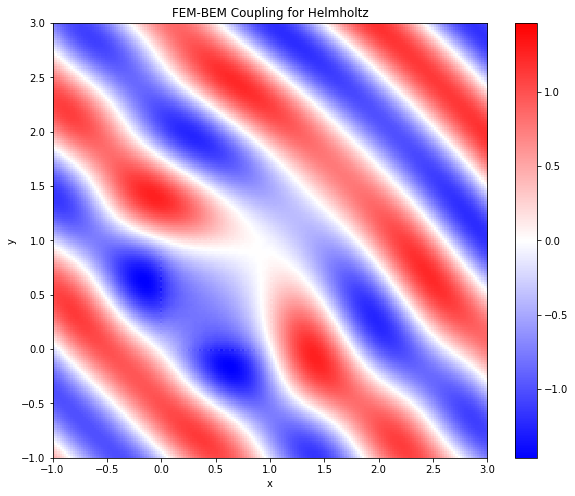

In [11]:
%matplotlib inline

Nx=200
Ny=200
xmin, xmax, ymin, ymax=[-1,3,-1,3]
plot_grid = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.array([0.5]*plot_grid[0].size)))
plot_me = np.zeros(points.shape[1], dtype=np.complex128)

x,y,z = points
bem_x = np.logical_not((x>0) * (x<1) * (y>0) * (y<1) * (z>0) * (z<1))

slp_pot= bempp.api.operators.potential.helmholtz.single_layer(
    bempp_space, points[:, bem_x], k)
dlp_pot= bempp.api.operators.potential.helmholtz.double_layer(
    trace_space, points[:, bem_x], k)

plot_me[bem_x] += np.exp(1j * k * (points[0, bem_x] * d[0] \
                                 + points[1, bem_x] * d[1] \
                                 + points[2, bem_x] * d[2]))
plot_me[bem_x] += dlp_pot.evaluate(dirichlet_fun).flat
plot_me[bem_x] -= slp_pot.evaluate(neumann_fun).flat

fem_points = points[:, np.logical_not(bem_x)].transpose()
tree = dolfinx.geometry.BoundingBoxTree(mesh, 3)
entities = []
for point in fem_points:
    entities.append(dolfinx.geometry.compute_closest_entity(tree, point, mesh)[0])
fem_val = u.eval(fem_points, entities)

plot_me[np.logical_not(bem_x)] += fem_val.T[0]

plot_me = plot_me.reshape((Nx, Ny))

plot_me = plot_me.transpose()[::-1]

vmax = np.max(np.abs(np.real(plot_me.flat)))

# Plot the image
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(10, 8))
plt.imshow(np.real(plot_me), extent=[xmin, xmax, ymin, ymax],
           cmap=plt.get_cmap("bwr"), vmin=-vmax, vmax=vmax)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("FEM-BEM Coupling for Helmholtz")
plt.show()